In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
np.set_printoptions(suppress = True)

In [2]:
ROCK, PAPER, SCISSORS = 0, 1, 2
NUM_ACTIONS = 3

In [3]:
def value(p1, p2):
    # p1 and p2 are the strategies adopted (in this case, moves played) by player 1 and player 2 respectively
    # the values p1 and p2 can take are 0, 1 and 2.
    if p1 == p2: # draw
        return 0
    elif (p1 - 1) % NUM_ACTIONS == p2:
        return 1
    else:
        return -1 # if it's neither a draw nor a win for p1, p2 wins

In [4]:
def normalize(strategy):
    # strategy is the mixed strategy which the player adopts in this game
    strategy = np.copy(strategy)
    normalizingSum = np.sum(strategy)
    # normalize the strategy array if its valid
    if normalizingSum > 0:
        strategy /= normalizingSum
    else: # create a uniform distribution over all possible moves
        strategy = np.ones(strategy.shape[0])/strategy.shape[0]
    return strategy

In [15]:
def getStrategy(regretSum):
    # keep only those regrets from the running regretSum which are positive, and clip the others to zero.
    # so basically, don't touch the moves with 0 or negative regret, and improve the moves with positive regret
    return normalize(np.maximum(regretSum, 0))

In [6]:
def getAction(strategy):
    strategy = strategy / np.sum(strategy) # normalize the strategy
    # the next lines simulates picking from that distribution. random.random() picks a float from Uniform(0, 1)
    # np.cumsum gives the cdf of strategy, over 0, 1 and 2. the np.searchsorted gives the index where the
    # randomly chosen number gets inserted according to its value relative to the value in np.cumsum(strategy)
    # so this effectively boils down to choosing one of 0, 1 or 2 according to the given distribution
    return np.searchsorted(np.cumsum(strategy), random.random())

In [7]:
def innertrain(regretSum, strategySum, oppStrategy):
    strategy = getStrategy(regretSum) # given the current regret, get the strategy for the next round
    strategySum += strategy # modify the strategySum using the current strategy
    myAction = getAction(strategy) # player's action from the current strategy, say 0
    
    # ROCK, PAPER, SCISSORS
    otherAction = getAction(oppStrategy) # opponent's action or move
    actionUtility = np.zeros(NUM_ACTIONS) # utility gained for each action
    actionUtility[otherAction] = 0 # zero utility for matching moves (draw)
    actionUtility[(otherAction + 1) % NUM_ACTIONS] = 1 # positive utility for winning moves
    actionUtility[(otherAction - 1) % NUM_ACTIONS] = -1 # negative utility for losing moves

    # find the difference between utility for opponent move, and your move, and add this to the running regretSum.
    # what this basically does is tell us the order in which it was preferable to play actions against the
    # opponent's current strategy
    # getAction(oppStrategy) = 1, say
    # actionUtility = [-1, 0, 1]
    # actionUtility[myAction] = actionUtility[0] = -1
    # actionUtility - actionUtility[0] = [-1, 0, 1] - (-1) = [0, 1, 2]
    # the above outcome shows that your strategy was the worst, and you regret not playing the better options
    # it also shows the differences in utilities/payoffs you missed out on by not playing those other moves
    # (applicable for the other moves too)
    # myAction = 1 => actionUtility - actionUtility[1] = [-1, 0, 1] - 0 = [-1, 0, 1]
    # the above outcome shows that your actions are unaffected by an indifferent outcome (a draw)
    # playing 0 would have lost you 1 point, and 2 would have gained you 1 point
    # myAction = 2 => actionUtility - actionUtility[2] = [-1, 0, 1] - 1 = [-2, -1, 0]
    # this is the best response to the opponent's action, as 0 and 1 result in you losing payoff
    # so you have negative regret, or in other words you don't regret not playing the other actions
    # so you update your regretSum with the regrets or the payoff/utility differences you gained/missed out on
    # this regretSum will influence your next strategy, and this is particularly useful and visible if the opponent
    # plays a biased strategy, as covered in this example.
    regretSum += actionUtility - actionUtility[myAction]
    
    return regretSum, strategySum

In [8]:
def train(iterations):
    regretSum = np.zeros(NUM_ACTIONS) # running sum of regrets for each move
    strategySum = np.zeros(NUM_ACTIONS) # running sum of player strategies
    # basically an accumulation of all the strategies that the player has played and
    # what it has finally converged to
    oppStrategy = np.array([0.4, 0.3, 0.3]) # fixed opponent strategy
    for i in range(iterations):
        # for the given oppStrategy, you start with zero regretSum and zero strategySum.
        # when you feed it for the first time, it starts with a uniform distribution as the strategy,
        # which is used to update the strategySum. then an action is chosen from the uniform strategy
        # and played to the opponent's action chosen from their strategy. the differences in utility,
        # or regret, is added to the running regretSum.
        # in the next iteration, the previous regret is used to form a new strategy, and this new
        # strategy is used to update strategySum
        # so basically strategySum has the past strategies. the current regretSum creates a new strategy
        # which is used to generate a new regret, which then is added to regretSum and influences future
        # strategies, and this cumulative effect of the strategy is stored in strategySum. i got how the
        # regretSum works, but the strategySum's actual working is a black box. i'll have to dig deeper later on.
        regretSum, strategySum = innertrain(regretSum, strategySum, oppStrategy)
    return strategySum

In [9]:
def train2p(oiterations, iterations):
    strategySumP1 = np.zeros(NUM_ACTIONS) # initializing strategies
    strategySumP2 = np.zeros(NUM_ACTIONS)

    for j in range(oiterations):
        oppStrategy = normalize(strategySumP2)
        regretSumP1 = np.zeros(NUM_ACTIONS)
        for i in range(iterations): # refine(?) P1's strategy given P2's initial strategy
            regretSumP1, strategySumP1 = innertrain(regretSumP1, strategySumP1, oppStrategy)
        
        oppStrategy = normalize(strategySumP1)
        regretSumP2 = np.zeros(NUM_ACTIONS)
        for i in range(iterations): # use P1's new strategy to update P2's strategy
            regretSumP2, strategySumP2 = innertrain(regretSumP2, strategySumP2, oppStrategy)

        # print(normalize(strategySumP1), normalize(strategySumP2))
    return strategySumP1, strategySumP2

In [10]:
s1, s2 = train2p(20, 1000)
print(s1, s2)
normalize(s1), normalize(s2)

[6674.03384166 6759.69530559 6566.27085275] [8366.39455477 5714.69112807 5918.91431716]


(array([0.33370169, 0.33798477, 0.32831354]),
 array([0.41831973, 0.28573456, 0.29594572]))

[ 10.35039683 989.14960317   0.5       ]
[0.0103504 0.9891496 0.0005   ]


([<matplotlib.lines.Line2D at 0x18fa318d670>], 9.355)

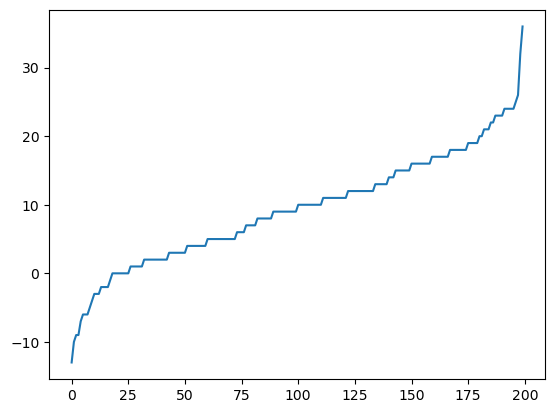

In [13]:
strategySum = train(1000)
print(strategySum)
strategy = normalize(strategySum)
print(strategy)
vvv = []
for j in range(200):
    vv = 0
    for i in range(100):
        myAction = getAction(strategy)
        otherAction = getAction([0.4, 0.3, 0.3])
        vv += value(myAction, otherAction)
    vvv.append(vv)
plt.plot(sorted(vvv)), np.mean(vvv)

([<matplotlib.lines.Line2D at 0x18fa30488e0>], -0.775)

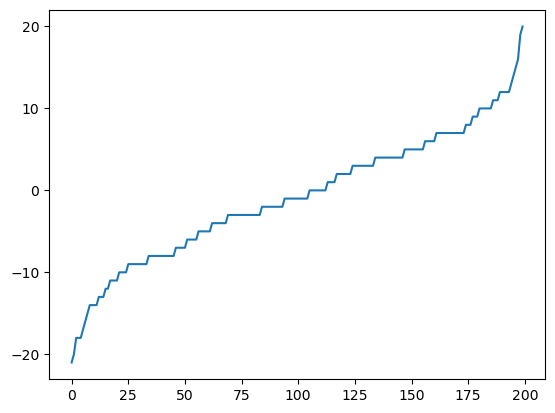

In [14]:
strategy, oppStrategy = normalize(s1), normalize(s2)
vvv = []
for j in range(200):
    vv = 0
    for i in range(100):
        myAction = getAction(strategy)
        otherAction = getAction(oppStrategy)
        vv += value(myAction, otherAction)
    vvv.append(vv)
plt.plot(sorted(vvv)), np.mean(vvv)